# Import library

In [1]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

2024-10-18 18:21:58.477564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 18:21:58.587212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 18:21:58.618906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 18:21:58.821526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 18:22:00.247805: W tensorflow/compiler/tf2

# EfficientNet Original

## Source code 

In [2]:
import copy
import math

from keras.src import backend
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.applications import imagenet_utils
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils

BASE_WEIGHTS_PATH = "https://storage.googleapis.com/keras-applications/"

WEIGHTS_HASHES = {
    "b0": (
        "902e53a9f72be733fc0bcb005b3ebbac",
        "50bc09e76180e00e4465e1a485ddc09d",
    ),
    "b1": (
        "1d254153d4ab51201f1646940f018540",
        "74c4e6b3e1f6a1eea24c589628592432",
    ),
    "b2": (
        "b15cce36ff4dcbd00b6dd88e7857a6ad",
        "111f8e2ac8aa800a7a99e3239f7bfb39",
    ),
    "b3": (
        "ffd1fdc53d0ce67064dc6a9c7960ede0",
        "af6d107764bb5b1abb91932881670226",
    ),
    "b4": (
        "18c95ad55216b8f92d7e70b3a046e2fc",
        "ebc24e6d6c33eaebbd558eafbeedf1ba",
    ),
    "b5": (
        "ace28f2a6363774853a83a0b21b9421a",
        "38879255a25d3c92d5e44e04ae6cec6f",
    ),
    "b6": (
        "165f6e37dce68623721b423839de8be5",
        "9ecce42647a20130c1f39a5d4cb75743",
    ),
    "b7": (
        "8c03f828fec3ef71311cd463b6759d99",
        "cbcfe4450ddf6f3ad90b1b398090fe4a",
    ),
}

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

BASE_DOCSTRING = """Instantiates the {name} architecture.

Reference:
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](
    https://arxiv.org/abs/1905.11946) (ICML 2019)

This function returns a Keras image classification model,
optionally loaded with weights pre-trained on ImageNet.

For image classification use cases, see
[this page for detailed examples](
https://keras.io/api/applications/#usage-examples-for-image-classification-models).

For transfer learning use cases, make sure to read the
[guide to transfer learning & fine-tuning](
https://keras.io/guides/transfer_learning/).

Note: each Keras Application expects a specific kind of input preprocessing.
For EfficientNet, input preprocessing is included as part of the model
(as a `Rescaling` layer), and thus
`keras.applications.efficientnet.preprocess_input` is actually a
pass-through function. EfficientNet models expect their inputs to be float
tensors of pixels with values in the `[0-255]` range.

Args:
    include_top: Whether to include the fully-connected
        layer at the top of the network. Defaults to `True`.
    weights: One of `None` (random initialization),
        `"imagenet"` (pre-training on ImageNet),
        or the path to the weights file to be loaded.
        Defaults to `"imagenet"`.
    input_tensor: Optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
        if `include_top` is False.
        It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
        when `include_top` is `False`. Defaults to `None`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
    classes: Optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified. 1000 is how many
        ImageNet classes there are. Defaults to `1000`.
    classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        Defaults to `'softmax'`.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.

Returns:
    A model instance.
"""


IMAGENET_STDDEV_RGB = [0.229, 0.224, 0.225]


def EfficientNet(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    activation="swish",
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates the EfficientNet architecture.

    Args:
      width_coefficient: float, scaling coefficient for network width.
      depth_coefficient: float, scaling coefficient for network depth.
      default_size: integer, default input image size.
      dropout_rate: float, dropout rate before final classifier layer.
      drop_connect_rate: float, dropout rate at skip connections.
      depth_divisor: integer, a unit of network width.
      activation: activation function.
      blocks_args: list of dicts, parameters to construct block modules.
      model_name: string, model name.
      include_top: whether to include the fully-connected
          layer at the top of the network.
      weights: one of `None` (random initialization),
            'imagenet' (pre-training on ImageNet),
            or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
          (i.e. output of `layers.Input()`)
          to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
          if `include_top` is False.
          It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction
          when `include_top` is `False`.
          - `None` means that the output of the model will be
              the 4D tensor output of the
              last convolutional layer.
          - `avg` means that global average pooling
              will be applied to the output of the
              last convolutional layer, and thus
              the output of the model will be a 2D tensor.
          - `max` means that global max pooling will
              be applied.
      classes: optional number of classes to classify images
          into, only to be specified if `include_top` is True, and
          if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
          on the "top" layer. Ignored unless `include_top=True`. Set
          `classifier_activation=None` to return the logits of the "top" layer.

    Returns:
        A model instance.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights="imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(
            divisor, int(filters + divisor / 2) // divisor * divisor
        )
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input
    x = layers.Rescaling(1.0 / 255.0)(x)
    x = layers.Normalization(axis=bn_axis)(x)
    if weights == "imagenet":
        # Note that the normaliztion layer uses square value of STDDEV as the
        # variance for the layer: result = (input - mean) / sqrt(var)
        # However, the original implemenetation uses (input - mean) / var to
        # normalize the input, we need to divide another sqrt(var) to match the
        # original implementation.
        # See https://github.com/tensorflow/tensorflow/issues/49930 for more
        # details
        x = layers.Rescaling(
            [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
        )(x)

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        round_filters(32),
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.Activation(activation, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)

    b = 0
    blocks = float(sum(round_repeats(args["repeats"]) for args in blocks_args))
    for i, args in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        for j in range(round_repeats(args.pop("repeats"))):
            # The first block needs to take care of stride and filter size
            # increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                activation,
                drop_connect_rate * b / blocks,
                name=f"block{i + 1}{chr(j + 97)}_",
                **args,
            )
            b += 1

    # Build top
    x = layers.Conv2D(
        round_filters(1280),
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.Activation(activation, name="top_activation")(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Functional(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        if include_top:
            file_suffix = ".h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][0]
        else:
            file_suffix = "_notop.h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][1]
        file_name = model_name + file_suffix
        weights_path = file_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    return model


def block(
    inputs,
    activation="swish",
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    se_ratio=0.0,
    id_skip=True,
):
    """An inverted residual block.

    Args:
        inputs: input tensor.
        activation: activation function.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        se_ratio: float between 0 and 1, fraction to squeeze the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.Activation(activation, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size),
            name=name + "dwconv_pad",
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.Activation(activation, name=name + "activation")(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
        if bn_axis == 1:
            se_shape = (filters, 1, 1)
        else:
            se_shape = (1, 1, filters)
        se = layers.Reshape(se_shape, name=name + "se_reshape")(se)
        se = layers.Conv2D(
            filters_se,
            1,
            padding="same",
            activation=activation,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_reduce",
        )(se)
        se = layers.Conv2D(
            filters,
            1,
            padding="same",
            activation="sigmoid",
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_expand",
        )(se)
        x = layers.multiply([x, se], name=name + "se_excite")

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB0",
        "keras.applications.EfficientNetB0",
    ]
)
def EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.0,
        224,
        0.2,
        model_name="efficientnetb0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB1",
        "keras.applications.EfficientNetB1",
    ]
)
def EfficientNetB1(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.1,
        240,
        0.2,
        model_name="efficientnetb1",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB2",
        "keras.applications.EfficientNetB2",
    ]
)
def EfficientNetB2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.1,
        1.2,
        260,
        0.3,
        model_name="efficientnetb2",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB3",
        "keras.applications.EfficientNetB3",
    ]
)
def EfficientNetB3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.2,
        1.4,
        300,
        0.3,
        model_name="efficientnetb3",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB4",
        "keras.applications.EfficientNetB4",
    ]
)
def EfficientNetB4(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.4,
        1.8,
        380,
        0.4,
        model_name="efficientnetb4",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB5",
        "keras.applications.EfficientNetB5",
    ]
)
def EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.6,
        2.2,
        456,
        0.4,
        model_name="efficientnetb5",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB6",
        "keras.applications.EfficientNetB6",
    ]
)
def EfficientNetB6(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.8,
        2.6,
        528,
        0.5,
        model_name="efficientnetb6",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB7",
        "keras.applications.EfficientNetB7",
    ]
)
def EfficientNetB7(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        2.0,
        3.1,
        600,
        0.5,
        model_name="efficientnetb7",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


EfficientNetB0.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB0")
EfficientNetB1.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB1")
EfficientNetB2.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB2")
EfficientNetB3.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB3")
EfficientNetB4.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB4")
EfficientNetB5.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB5")
EfficientNetB6.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB6")
EfficientNetB7.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB7")


@keras_export("keras.applications.efficientnet.preprocess_input")
def preprocess_input(x, data_format=None):
    """A placeholder method for backward compatibility.

    The preprocessing logic has been included in the efficientnet model
    implementation. Users are no longer required to call this method to
    normalize the input data. This method does nothing and only kept as a
    placeholder to align the API surface between old and new version of model.

    Args:
        x: A floating point `numpy.array` or a tensor.
        data_format: Optional data format of the image tensor/array. `None`
            means the global setting `keras.backend.image_data_format()`
            is used (unless you changed it, it uses `"channels_last"`).
            Defaults to `None`.

    Returns:
        Unchanged `numpy.array` or tensor.
    """
    return x


@keras_export("keras.applications.efficientnet.decode_predictions")
def decode_predictions(preds, top=5):
    return imagenet_utils.decode_predictions(preds, top=top)


decode_predictions.__doc__ = imagenet_utils.decode_predictions.__doc__

## Define Function

In [3]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [4]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs):
    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Menghitung waktu mulai pelatihan
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping_callback]
    )
    
    # Menghitung waktu selesai pelatihan
    end_time = time.time()
    
    # Menghitung durasi pelatihan
    training_duration = end_time - start_time  # dalam detik

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Tampilkan confusion matrix
    plt.show()

    return history, test_loss, test_accuracy, training_duration


## Training menggunakan EfficientNet Not Modified Weights imagenet

In [5]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

# Freeze 50% layer pertama dari base model
total_layers = len(model.layers)
freeze_layers = int(0.50 * total_layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

I0000 00:00:1729247576.052592    6933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729247576.323908    6933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729247576.323980    6933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729247576.329439    6933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729247576.329524    6933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,446 (16.85 MB)

 Trainable params: 4,063,435 (15.50 MB)

 Non-trainable params: 354,011 (1.35 MB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1729240792.220684    2935 service.cc:146] XLA service 0x7f87e8004320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729240792.220733    2935 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-18 15:39:52.879124: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 15:39:55.319982: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729240803.765417    2935 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729240803.996046    2935 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

 9/87 ━━━━━━━━━━━━━━━━━━━━ 15s 201ms/step - accuracy: 0.3154 - loss: 1.9266

E0000 00:00:1729240832.623154    2938 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729240832.895228    2938 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 107s 699ms/step - accuracy: 0.3520 - loss: 1.6129 - val_accuracy: 0.4770 - val_loss: 1.0456
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.3947 - loss: 1.4708 - val_accuracy: 0.5172 - val_loss: 0.9930
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.4656 - loss: 1.2794 - val_accuracy: 0.5891 - val_loss: 0.9184
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.5384 - loss: 1.0933 - val_accuracy: 0.6264 - val_loss: 0.8427
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 268ms/step - accuracy: 0.5747 - loss: 1.0137 - val_accuracy: 0.6724 - val_loss: 0.7660
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.5946 - loss: 0.9225 - val_accuracy: 0.7040 - val_loss: 0.7070
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.6312 - loss: 0.8951 - val_accuracy: 0.7443 - val_loss: 0.6416
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.6581 - loss: 0.8505 - val_accuracy: 0.77

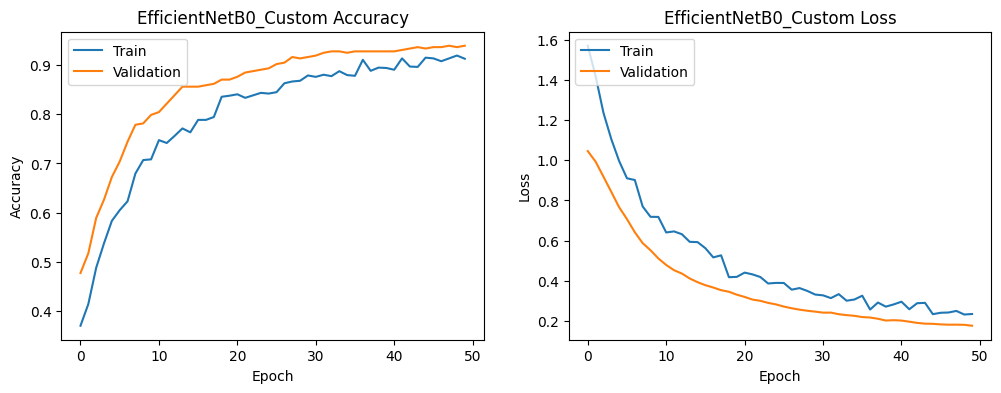

160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8946 - loss: 0.3126
Test Accuracy: 0.7992
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.89      0.93      0.91      1645
        rust       0.73      0.25      0.37       275
        scab       0.59      0.69      0.64       630

    accuracy                           0.80      2550
   macro avg       0.74      0.62      0.64      2550
weighted avg       0.80      0.80      0.79      2550



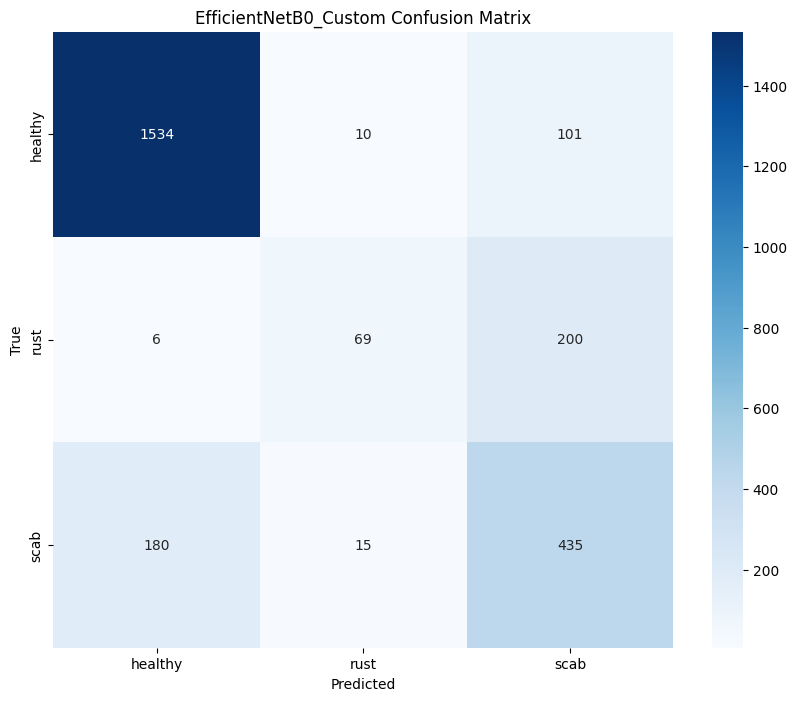

In [7]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB0_Custom", train_generator, validation_generator, test_generator, 50)

## Training menggunakan EfficientNet Not Modified Weights None

In [8]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,446 (16.85 MB)

 Trainable params: 4,372,095 (16.68 MB)

 Non-trainable params: 45,351 (177.16 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 129s 758ms/step - accuracy: 0.3555 - loss: 1.5927 - val_accuracy: 0.3592 - val_loss: 1.1133
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.3485 - loss: 1.4797 - val_accuracy: 0.2989 - val_loss: 1.1336
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.3972 - loss: 1.4702 - val_accuracy: 0.2989 - val_loss: 1.1362
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.3507 - loss: 1.4285 - val_accuracy: 0.2989 - val_loss: 1.1855
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.3804 - loss: 1.4032 - val_accuracy: 0.2816 - val_loss: 1.2179
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step - accuracy: 0.4015 - loss: 1.3899 - val_accuracy: 0.3218 - val_loss: 1.1897


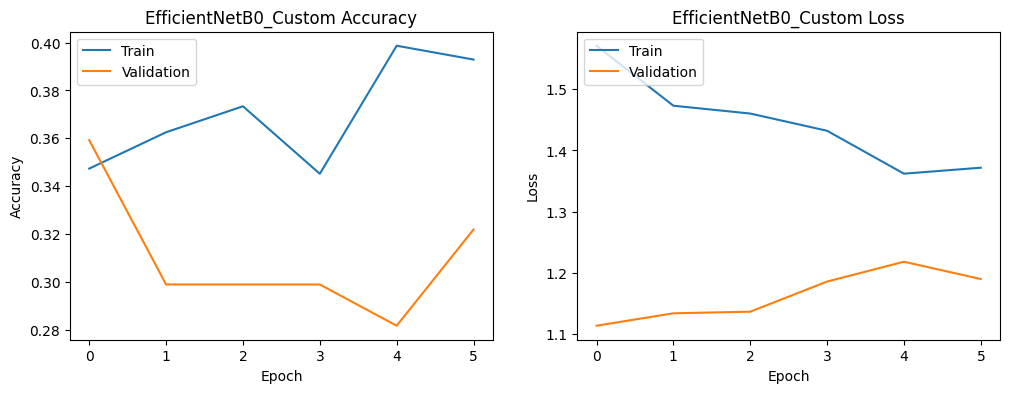

160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.0398 - loss: 1.0690
Test Accuracy: 0.1078
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.11      1.00      0.19       275
        scab       0.00      0.00      0.00       630

    accuracy                           0.11      2550
   macro avg       0.04      0.33      0.06      2550
weighted avg       0.01      0.11      0.02      2550



/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

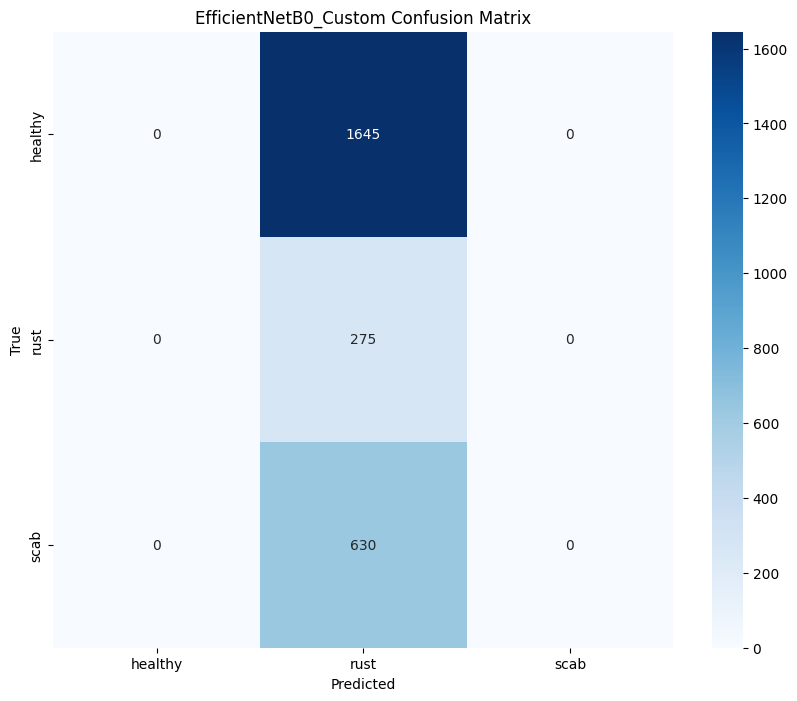

In [9]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB0_Custom", train_generator, validation_generator, test_generator, 50)

In [6]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,798,362 (247.19 MB)

 Trainable params: 64,481,747 (245.98 MB)

 Non-trainable params: 316,615 (1.21 MB)

# EfficientNet Modified

## Source Code

In [2]:
import copy
import math

from keras.src import backend
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.applications import imagenet_utils
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils

BASE_WEIGHTS_PATH = "https://storage.googleapis.com/keras-applications/"

WEIGHTS_HASHES = {
    "b0": (
        "902e53a9f72be733fc0bcb005b3ebbac",
        "50bc09e76180e00e4465e1a485ddc09d",
    ),
    "b1": (
        "1d254153d4ab51201f1646940f018540",
        "74c4e6b3e1f6a1eea24c589628592432",
    ),
    "b2": (
        "b15cce36ff4dcbd00b6dd88e7857a6ad",
        "111f8e2ac8aa800a7a99e3239f7bfb39",
    ),
    "b3": (
        "ffd1fdc53d0ce67064dc6a9c7960ede0",
        "af6d107764bb5b1abb91932881670226",
    ),
    "b4": (
        "18c95ad55216b8f92d7e70b3a046e2fc",
        "ebc24e6d6c33eaebbd558eafbeedf1ba",
    ),
    "b5": (
        "ace28f2a6363774853a83a0b21b9421a",
        "38879255a25d3c92d5e44e04ae6cec6f",
    ),
    "b6": (
        "165f6e37dce68623721b423839de8be5",
        "9ecce42647a20130c1f39a5d4cb75743",
    ),
    "b7": (
        "8c03f828fec3ef71311cd463b6759d99",
        "cbcfe4450ddf6f3ad90b1b398090fe4a",
    ),
}

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 1,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 1,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 1,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

BASE_DOCSTRING = """Instantiates the {name} architecture.

Reference:
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](
    https://arxiv.org/abs/1905.11946) (ICML 2019)

This function returns a Keras image classification model,
optionally loaded with weights pre-trained on ImageNet.

For image classification use cases, see
[this page for detailed examples](
https://keras.io/api/applications/#usage-examples-for-image-classification-models).

For transfer learning use cases, make sure to read the
[guide to transfer learning & fine-tuning](
https://keras.io/guides/transfer_learning/).

Note: each Keras Application expects a specific kind of input preprocessing.
For EfficientNet, input preprocessing is included as part of the model
(as a `Rescaling` layer), and thus
`keras.applications.efficientnet.preprocess_input` is actually a
pass-through function. EfficientNet models expect their inputs to be float
tensors of pixels with values in the `[0-255]` range.

Args:
    include_top: Whether to include the fully-connected
        layer at the top of the network. Defaults to `True`.
    weights: One of `None` (random initialization),
        `"imagenet"` (pre-training on ImageNet),
        or the path to the weights file to be loaded.
        Defaults to `"imagenet"`.
    input_tensor: Optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
        if `include_top` is False.
        It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
        when `include_top` is `False`. Defaults to `None`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
    classes: Optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified. 1000 is how many
        ImageNet classes there are. Defaults to `1000`.
    classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        Defaults to `'softmax'`.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.

Returns:
    A model instance.
"""


IMAGENET_STDDEV_RGB = [0.229, 0.224, 0.225]


def EfficientNet(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    activation="swish",
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates the EfficientNet architecture.

    Args:
      width_coefficient: float, scaling coefficient for network width.
      depth_coefficient: float, scaling coefficient for network depth.
      default_size: integer, default input image size.
      dropout_rate: float, dropout rate before final classifier layer.
      drop_connect_rate: float, dropout rate at skip connections.
      depth_divisor: integer, a unit of network width.
      activation: activation function.
      blocks_args: list of dicts, parameters to construct block modules.
      model_name: string, model name.
      include_top: whether to include the fully-connected
          layer at the top of the network.
      weights: one of `None` (random initialization),
            'imagenet' (pre-training on ImageNet),
            or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
          (i.e. output of `layers.Input()`)
          to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
          if `include_top` is False.
          It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction
          when `include_top` is `False`.
          - `None` means that the output of the model will be
              the 4D tensor output of the
              last convolutional layer.
          - `avg` means that global average pooling
              will be applied to the output of the
              last convolutional layer, and thus
              the output of the model will be a 2D tensor.
          - `max` means that global max pooling will
              be applied.
      classes: optional number of classes to classify images
          into, only to be specified if `include_top` is True, and
          if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
          on the "top" layer. Ignored unless `include_top=True`. Set
          `classifier_activation=None` to return the logits of the "top" layer.

    Returns:
        A model instance.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights="imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(
            divisor, int(filters + divisor / 2) // divisor * divisor
        )
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input
    x = layers.Rescaling(1.0 / 255.0)(x)
    x = layers.Normalization(axis=bn_axis)(x)
    if weights == "imagenet":
        # Note that the normaliztion layer uses square value of STDDEV as the
        # variance for the layer: result = (input - mean) / sqrt(var)
        # However, the original implemenetation uses (input - mean) / var to
        # normalize the input, we need to divide another sqrt(var) to match the
        # original implementation.
        # See https://github.com/tensorflow/tensorflow/issues/49930 for more
        # details
        x = layers.Rescaling(
            [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
        )(x)

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        round_filters(32),
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.Activation(activation, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)

    b = 0
    blocks = float(sum(round_repeats(args["repeats"]) for args in blocks_args))
    for i, args in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        for j in range(round_repeats(args.pop("repeats"))):
            # The first block needs to take care of stride and filter size
            # increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                activation,
                drop_connect_rate * b / blocks,
                name=f"block{i + 1}{chr(j + 97)}_",
                **args,
            )
            b += 1

    # Build top
    x = layers.Conv2D(
        round_filters(1280),
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.Activation(activation, name="top_activation")(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Functional(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        if include_top:
            file_suffix = ".h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][0]
        else:
            file_suffix = "_notop.h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][1]
        file_name = model_name + file_suffix
        weights_path = file_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    return model


def block(
    inputs,
    activation="swish",
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    se_ratio=0.0,
    id_skip=True,
):
    """An inverted residual block.

    Args:
        inputs: input tensor.
        activation: activation function.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        se_ratio: float between 0 and 1, fraction to squeeze the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.Activation(activation, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size),
            name=name + "dwconv_pad",
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.Activation(activation, name=name + "activation")(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
        if bn_axis == 1:
            se_shape = (filters, 1, 1)
        else:
            se_shape = (1, 1, filters)
        se = layers.Reshape(se_shape, name=name + "se_reshape")(se)
        se = layers.Conv2D(
            filters_se,
            1,
            padding="same",
            activation=activation,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_reduce",
        )(se)
        se = layers.Conv2D(
            filters,
            1,
            padding="same",
            activation="sigmoid",
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_expand",
        )(se)
        x = layers.multiply([x, se], name=name + "se_excite")

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB0",
        "keras.applications.EfficientNetB0",
    ]
)
def EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.0,
        224,
        0.2,
        model_name="efficientnetb0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB1",
        "keras.applications.EfficientNetB1",
    ]
)
def EfficientNetB1(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.1,
        240,
        0.2,
        model_name="efficientnetb1",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB2",
        "keras.applications.EfficientNetB2",
    ]
)
def EfficientNetB2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.1,
        1.2,
        260,
        0.3,
        model_name="efficientnetb2",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB3",
        "keras.applications.EfficientNetB3",
    ]
)
def EfficientNetB3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.2,
        1.4,
        300,
        0.3,
        model_name="efficientnetb3",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB4",
        "keras.applications.EfficientNetB4",
    ]
)
def EfficientNetB4(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.4,
        1.8,
        380,
        0.4,
        model_name="efficientnetb4",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB5",
        "keras.applications.EfficientNetB5",
    ]
)
def EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.6,
        2.2,
        456,
        0.4,
        model_name="efficientnetb5",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB6",
        "keras.applications.EfficientNetB6",
    ]
)
def EfficientNetB6(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.8,
        2.6,
        528,
        0.5,
        model_name="efficientnetb6",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB7",
        "keras.applications.EfficientNetB7",
    ]
)
def EfficientNetB7(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        2.0,
        3.1,
        600,
        0.5,
        model_name="efficientnetb7",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


EfficientNetB0.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB0")
EfficientNetB1.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB1")
EfficientNetB2.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB2")
EfficientNetB3.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB3")
EfficientNetB4.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB4")
EfficientNetB5.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB5")
EfficientNetB6.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB6")
EfficientNetB7.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB7")


@keras_export("keras.applications.efficientnet.preprocess_input")
def preprocess_input(x, data_format=None):
    """A placeholder method for backward compatibility.

    The preprocessing logic has been included in the efficientnet model
    implementation. Users are no longer required to call this method to
    normalize the input data. This method does nothing and only kept as a
    placeholder to align the API surface between old and new version of model.

    Args:
        x: A floating point `numpy.array` or a tensor.
        data_format: Optional data format of the image tensor/array. `None`
            means the global setting `keras.backend.image_data_format()`
            is used (unless you changed it, it uses `"channels_last"`).
            Defaults to `None`.

    Returns:
        Unchanged `numpy.array` or tensor.
    """
    return x


@keras_export("keras.applications.efficientnet.decode_predictions")
def decode_predictions(preds, top=5):
    return imagenet_utils.decode_predictions(preds, top=top)


decode_predictions.__doc__ = imagenet_utils.decode_predictions.__doc__

## Define Function

In [3]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [4]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs):
    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Menghitung waktu mulai pelatihan
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping_callback]
    )
    
    # Menghitung waktu selesai pelatihan
    end_time = time.time()
    
    # Menghitung durasi pelatihan
    training_duration = end_time - start_time  # dalam detik

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Tampilkan confusion matrix
    plt.show()

    return history, test_loss, test_accuracy, training_duration


## Training menggunakan EfficientNet Modified

### B0

In [13]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     1,594,147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,962,022 (7.48 MB)

 Trainable params: 1,943,295 (7.41 MB)

 Non-trainable params: 18,727 (73.16 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 107s 560ms/step - accuracy: 0.3448 - loss: 1.5821 - val_accuracy: 0.2989 - val_loss: 1.1883
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.3490 - loss: 1.5184 - val_accuracy: 0.2989 - val_loss: 1.3020
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.3439 - loss: 1.5024 - val_accuracy: 0.2989 - val_loss: 1.4705
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.3748 - loss: 1.4621 - val_accuracy: 0.2989 - val_loss: 1.2865
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.3818 - loss: 1.4519 - val_accuracy: 0.2874 - val_loss: 1.2984
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.3556 - loss: 1.4624 - val_accuracy: 0.3362 - val_loss: 1.1693
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.3955 - loss: 1.3849 - val_accuracy: 0.3362 - val_loss: 1.2365
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.4087 - loss: 1.3306 - val_acc

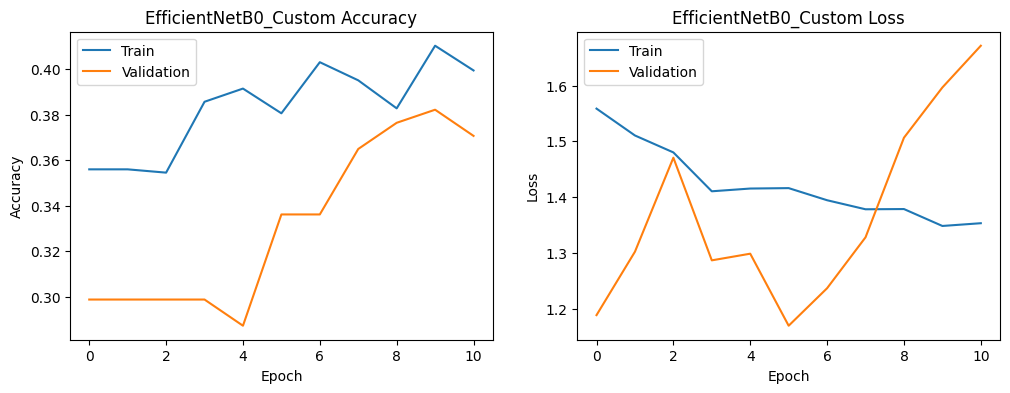

160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6371 - loss: 0.8237
Test Accuracy: 0.4922
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.63      0.69      0.66      1645
        rust       0.01      0.01      0.01       275
        scab       0.28      0.20      0.23       630

    accuracy                           0.49      2550
   macro avg       0.31      0.30      0.30      2550
weighted avg       0.48      0.49      0.48      2550



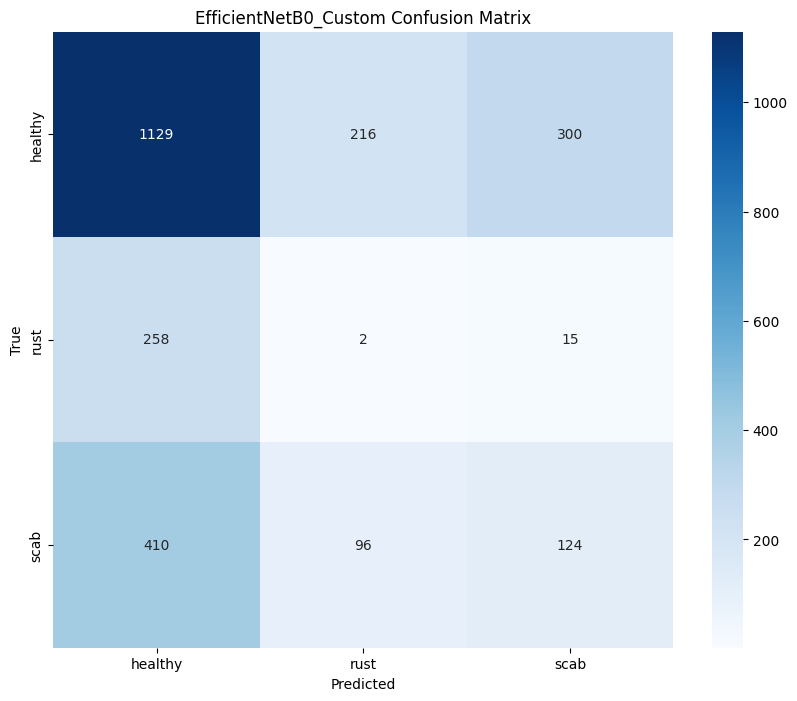

In [14]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B0, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB0_Custom", train_generator, validation_generator, test_generator, 50)

### B7

In [10]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    35,806,103 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,506,778 (139.26 MB)

 Trainable params: 36,349,907 (138.66 MB)

 Non-trainable params: 156,871 (612.78 KB)

In [11]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 50)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1729247662.763797    7011 service.cc:146] XLA service 0x7fa1f80027a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729247662.763937    7011 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-18 17:34:24.331318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 17:34:30.123069: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-18 17:34:44.500004: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=1,k4=1,k5=1,k6=0,k7=0} for conv (f32[16,64,300,300]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,300,300]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", backend_config={"

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_6933/3973529554.py", line 8, in <module>

  File "/tmp/ipykernel_6933/3039534177.py", line 10, in train_and_plot

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 21097264592 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_95684]

# Test KFold

In [6]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


In [ ]:
import numpy as np

# Ekstrak seluruh data dan label dari generator
def extract_images_labels(generator):
    images = []
    labels = []
    for _ in range(len(generator)):  # Iterasi untuk setiap batch
        img_batch, label_batch = next(generator)
        images.append(img_batch)
        labels.append(label_batch)
    
    # Menggabungkan list menjadi array numpy
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    
    return images, labels

# Ekstrak data dari train_generator
train_images, train_labels = extract_images_labels(train_generator)


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Assuming you have train data and labels loaded, e.g., train_images, train_labels
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1

# Inisialisasi variabel untuk menyimpan hasil
acc_per_fold = []
loss_per_fold = []

# K-Fold Cross Validation model evaluation
for train_index, val_index in kfold.split(train_images, train_labels):
    print(f'Training for fold {fold_no} ...')

    # Split data into training and validation sets for the current fold
    x_train_fold = train_images[train_index]
    y_train_fold = train_labels[train_index]
    x_val_fold = train_images[val_index]
    y_val_fold = train_labels[val_index]

    # Create model for this fold
    model = EfficientNetB1(input_shape=(600, 600, 3), include_top=False, weights=None)
    model.trainable = True
    
    inputs = Input(shape=(600, 600, 3))
    x = model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for this fold
    history = model.fit(x_train_fold, y_train_fold,
                        epochs=50,
                        batch_size=16,
                        validation_data=(x_val_fold, y_val_fold))

    # Mengevaluasi model di data validasi
    scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

# Menampilkan hasil akhir dari cross-validation
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')